In [1]:
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import IPython
from IPython.display import display, clear_output
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from packages.data_generation import DG
from packages.Regressors import GLM, RSP, NSP, GAMs
from packages.Util import CV, GD
from packages.Regressors import LinearReg
from packages.Regularizers import L1, L2

from sklearn import svm
from sklearn import datasets
import sklearn
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, SGDClassifier, Ridge

# The model used to generate data
The data follows the process below: $$x \sim N(0,1),~~~~f(x)=1+x+0.3sin(10x)$$

In [2]:
N = 100
noise = 0.1
dim = 1
x_full, y_full = DG(N, noise, dim).Gaussianbased_data1(0., 1.) #data generation

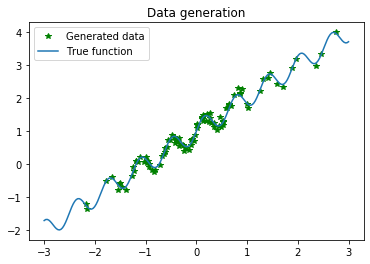

In [3]:
#a quick look at how data looks like
x_plt = np.linspace(-3, 3, 200)
y_plt = 1 + x_plt + 0.3 * np.sin(10*x_plt)
fig, ax = plt.subplots()
ax.plot(x_full, y_full, 'g*', label='Generated data')
ax.plot(x_plt, y_plt, label='True function')
ax.set_title('Data generation')
ax.legend() 

# Regression Splines and Natural Splines
Below we show how natural regression splines fit the data with non-linear features. Relevant materials can be found in ISLR(https://www.statlearning.com/) and ESL (https://web.stanford.edu/~hastie/ElemStatLearn/) book.

In [7]:
"""
Regression splines are not stable at the boundary and possess higher degree of freedom.
"""
RS = RSP(x_full, y_full, 3, 10)
y1_test = RS.predict(x_plt)

In [8]:
"""
Natural splines add constraints on the two boundaries and remove 4 degrees of freedom, to keep the function is linear
at the boundary. It is smoother than Regression splines.
"""
NS = NSP(x_full, y_full, 3, 10)
y2_test = NS.predict(x_plt)

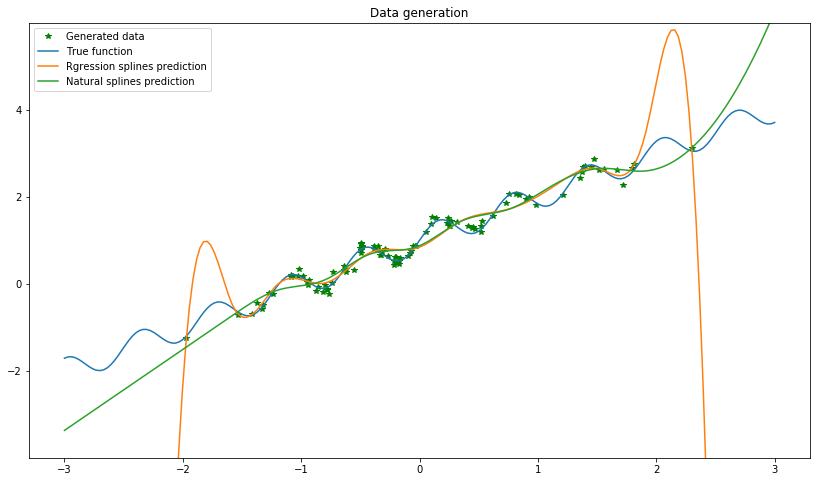

In [10]:
fig,ax = plt.subplots(figsize=(14,8))
ax.plot(x_full, y_full, 'g*', label='Generated data')
ax.plot(x_plt, y_plt, label='True function')
ax.plot(x_plt, y1_test, label="Rgression splines prediction")
ax.plot(x_plt, y2_test, label="Natural splines prediction")
ax.set_title('Data generation')
ax.set_ylim(np.min(y_plt)-2, np.max(y_plt)+2)
ax.legend() 

We can observe a much more stable prediction at the boundaries for natural splines than regression splines, it keeps prediction at the boundaries from exploding!

# GAMs
Natural regression spline can be seen as a specific GAMs in 1-D, here we represent GAMs by natural splines. As seen that regression splines cannot be used to fit the multil-dimensional data, but GAMs can! It is simply an additive model with splines. Say we build a natural spline for each feature and stack them together. The algorithm is quite similar, I write a general GAMs class that can also be used for 1-D data, in this situation its just the same as natural spline.

**$\star$**Here I show GAMs stacked by natural splines instead of normal regression splines.

In [62]:
N = 100
noise = 0.1
dim = 1
x, y = DG(N, noise, dim).D2_data(0., 1.)

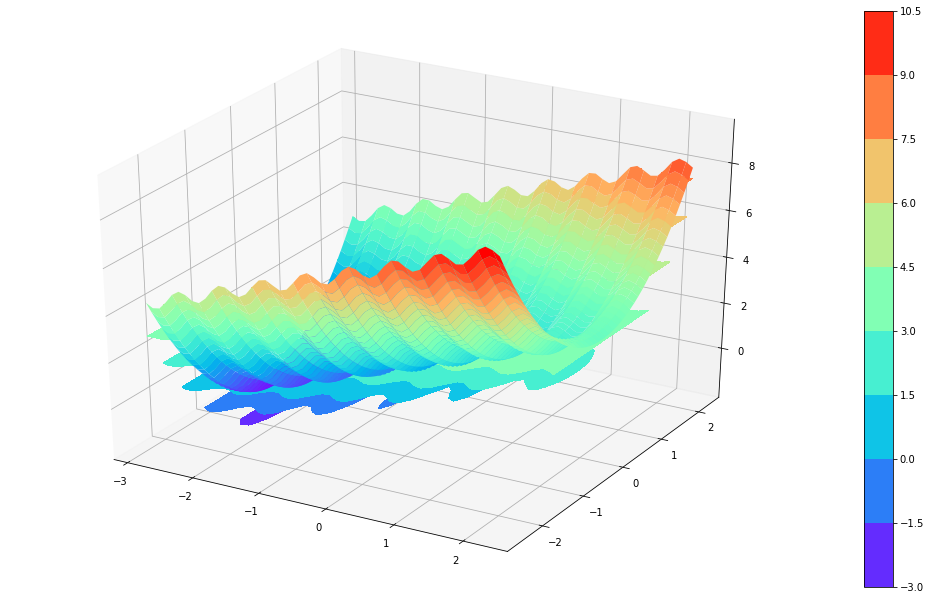

In [63]:
fig=plt.figure(figsize=(14,8))
ax=Axes3D(fig)
#fig, ax = plt.subplots(figsize=(14,8))
min1, max1 = x[:,0].min()-0.5, x[:,0].max()+0.5
min2, max2 = x[:,1].min()-0.5, x[:,1].max()+0.5
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
zz = (1 + xx + 0.3 * np.sin(10*xx)) + yy**2
ax.plot_surface(xx,yy,zz,cmap="rainbow")
c = ax.contourf(xx, yy, zz, zdir="z", cmap="rainbow")
plt.colorbar(c)
plt.show()

Above we generate some 2-D data and a continous 3-dimensional plot with the same model.

In [68]:
GS = GAMs(x, y, [3,3], [20,10])
#y_test = GG.predict(x_plt)

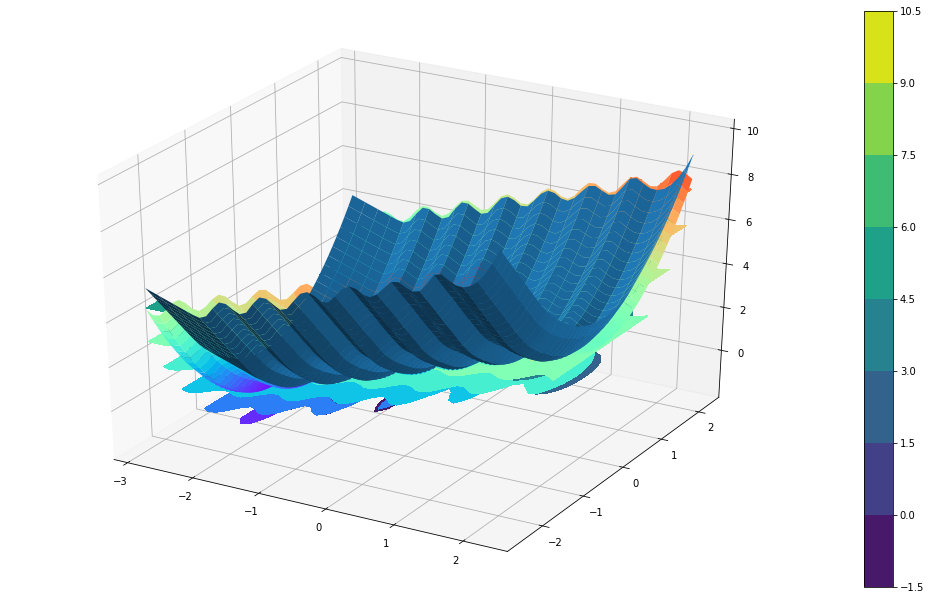

In [69]:
fig=plt.figure(figsize=(14,8))
ax=Axes3D(fig)
min1, max1 = x[:,0].min()-0.5, x[:,0].max()+0.5
min2, max2 = x[:,1].min()-0.5, x[:,1].max()+0.5
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
zz = GS.predict(grid).reshape(xx.shape)
ax.plot_surface(xx,yy,zz)
c = ax.contourf(xx, yy, zz, zdir="z")
zz_true = (1 + xx + 0.3 * np.sin(10*xx)) + yy**2
ax.plot_surface(xx,yy,zz_true,cmap="rainbow")
c_true = ax.contourf(xx, yy, zz_true, zdir="z", cmap="rainbow")

plt.colorbar(c)
#ax.set_zlim(-2,8)

As we can see GAMs performs quite well as it vastly overlaps with the true surfaces. But an obvious drawback is that it does not predict well for testing data that is far away from training data (outlier).

# Building features and hand-selection
Now we will create a few candidate features and select them manually, finally we will evaluate the error by cross validation

In [119]:
opts = {'reg': 0.1,
       'features': {'exp(5x)'}
       } #this includes some parameters that are used in the regressor class.
def folds(folds):
    return CrossVal(x_full, y_full, folds, GLM, opts)
fold = ipywidgets.RadioButtons(options=[1,2,5,10],value=5,  layout={'width': 'max-content'},
                               description='Number of folds')
interact(folds, folds = fold) #this way we can use interact without assignning values to all parameters.

interactive(children=(RadioButtons(description='Number of folds', index=2, layout=Layout(width='max-content'),…

<function __main__.folds(folds)>

# Step forward selection
This is a manual feature selection method and we would deploy CV to evaluate the error, deciding which feature we should choose and how far we should stop.

Give $S=\emptyset$ and $E_0=\infty$, where $E_0$ is the intial error.

For i=1:d (d is the dimension of the feature space)

Find the best feature to add

$s_i=argmin_{j\in V\setminus S}CV(S\cup \{j\} )$

Compute error

$E_i=CV(S\cup s_i)$

If $E_i>E_{i-1}$, break

Else $S \leftarrow S\cup \{s_i\}$ 


Button(description='Next feature', style=ButtonStyle())

Added feature: sin(10x)
Feature space: {'exp(x)', 'cubic', 'exp(2x)', 'sin(10x)', 'quadratic'}
Coefficients are [-0.57784342 -0.15349647  0.32433043  1.04588658 -0.02100835]
Validation error is 0.018923136515116935


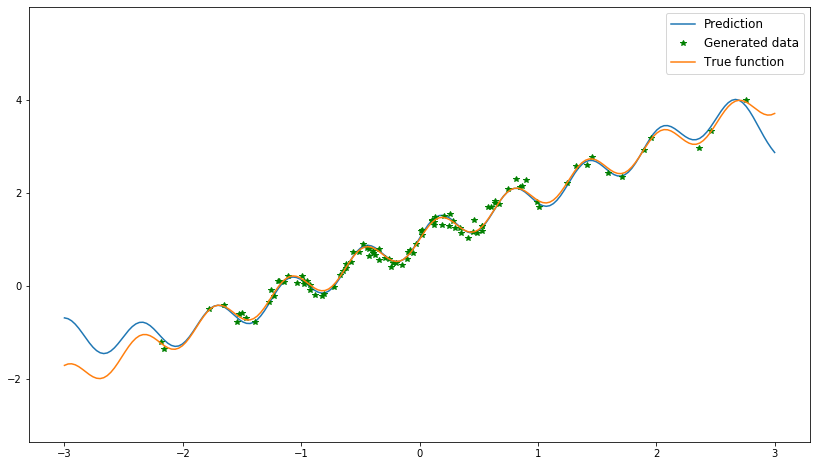

The best features are: {'exp(x)', 'cubic', 'exp(2x)', 'sin(10x)', 'quadratic'}
Coefficients are [-0.57784342 -0.15349647  0.32433043  1.04588658 -0.02100835]
Validation error is 0.018923136515116935


In [4]:
features_map = {'constant', 'linear', 'quadratic', 'cubic', 
            'sin(x)', 'sin(2x)', 'sin(5x)', 'sin(10x)',
            'exp(x)', 'exp(2x)', 'exp(5x)', 'exp(10x)'}
S = set() #initial features set: nothing
coe = None
E = float('+Inf') # initial error set to be the infinity
opts = {'reg': 0.1,
       'features': S}

def nextfeature(a):
    global E, coe #E and coe can be changed inside function. S and opts are assigned by reference will automatically change.
    error_bf = None
    bf = None
    features_mapr = features_map-S #select from those features not included yet.
    for feature in features_mapr:
        S.add(feature)
        error_after = CV(x_full, y_full, 5, GLM).CrossVal(True, opts)
        if error_bf is None or error_after < error_bf :
            error_bf = error_after #the CV error with the best feature added.
            bf = feature #the best feature.
        S.remove(feature) #recover S.
    if error_bf < E: # if new feature reduces the error, keep going.
        S.add(bf) # add back this new feature
        E = error_bf
        clear_output() # used to avoid showing too many outputs from 'click button'.
        display(button)  #show the button
        ob = GLM(x_full, y_full, opts.get('reg', 0.1), S) # call GLM class object to use some of its functions.
        coe = ob.w_hat()
        
        fig, ax = plt.subplots(figsize=(14,8))
        x_test = x_plt
        y_test = np.dot(ob.Phi(x_test), coe) #to compute the response, we need to first map original x to Phi(x).
        ax.plot(x_test, y_test, label='Prediction')
        ax.plot(x_full, y_full, 'g*', label='Generated data')
        ax.plot(x_plt, y_plt, label='True function')
        ax.set_ylim(min(y_full)-2, max(y_full)+2)  
        ax.legend(fontsize=12)
        
        print(f'Added feature: {bf}')
        print(f'Feature space: {S}')
        print(f'Coefficients are {coe}')
        print(f'Validation error is {E}')
    elif error_bf > E or len(features_mapr) == 0 : #if new feature increases error or feature set is done, finish.
        print(f'The best features are: {S}') # since no feature update, the plot still includes the best features
        print(f'Coefficients are {coe}')
        print(f'Validation error is {E}')
button = ipywidgets.Button(description='Next feature')
button.on_click(nextfeature)
nextfeature(None)

# Step backward selection
This is quite similar to forward selection method but processes in a reverse way.

Give $S=V$ and $E_0=\infty$, where $E_0$ is the initial error equipped with full features.

For i=1:d

Find the best feature to remove

$s_i=argmin_{j\in S}CV(S\setminus \{j\} )$

Compute error

$E_i=CV(S\setminus s_i)$

If $E_i>E_{i-1}$, break

Else $S \leftarrow S\setminus \{s_i\}$ 

Button(description='Remove next feature', style=ButtonStyle())

Removed feature: exp(10x)
Feature space: {'sin(x)', 'sin(2x)', 'exp(5x)', 'quadratic', 'constant', 'exp(2x)', 'sin(10x)', 'linear', 'sin(5x)', 'cubic', 'exp(x)'}
Coefficients are [ 5.03799010e-01  1.18094647e-01 -2.66628829e-01  2.40773357e-02
  1.12248292e-01  1.72484846e-01 -3.38946729e-02  3.00711653e-01
  4.80620305e-01  4.89311323e-03 -2.00045638e-05]
Validation error is 0.11249088909319829


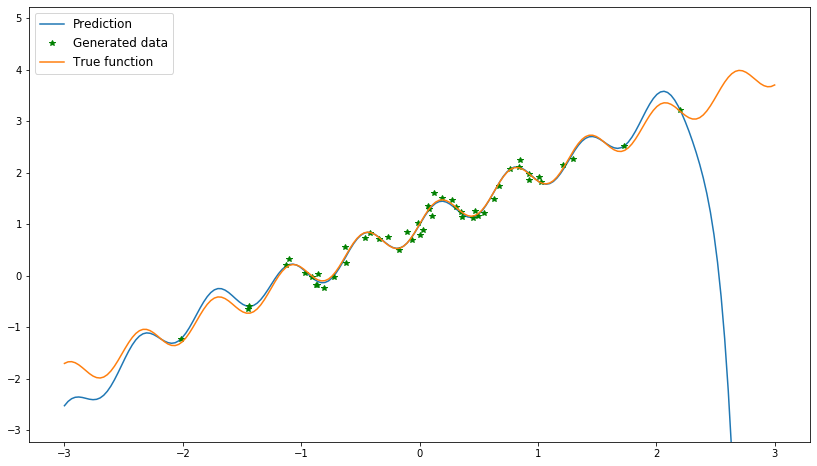

In [51]:
feature_map = {'constant', 'linear', 'quadratic', 'cubic', 
            'sin(x)', 'sin(2x)', 'sin(5x)', 'sin(10x)',
            'exp(x)', 'exp(2x)', 'exp(5x)', 'exp(10x)'}
S = feature_map - set() # we dont want the original feature space to be changed as we change S.
E = float("+inf")
coe = None
opts = opts = {'reg': 0.1,
       'features': S}

def nextfeature(a):
    global E, coe
    error_bf = None
    bf = None
    for feature in S:
        S.remove(feature)
        error_af = CV(x_full, y_full, 5, GLM).CrossVal(True, opts)
        if error_bf is None or error_af < error_bf:
            bf = feature
            error_bf = error_af
        S.add(feature)
    
    if error_bf < E:
        S.remove(bf)
        E = error_bf
        clear_output()
        display(button) #button only appears in this situation, can do the next run. 
        ob = GLM(x_full, y_full, opts.get("reg", 0.1), S)
        coe = ob.w_hat()
        
        fig, ax = plt.subplots(figsize=(14,8))
        x_test = x_plt
        y_test = np.dot(ob.Phi(x_test), coe) #to compute the response, we need to first map original x to Phi(x).
        ax.plot(x_test, y_test, label='Prediction')
        ax.plot(x_full, y_full, 'g*', label='Generated data')
        ax.plot(x_plt, y_plt, label='True function')
        ax.set_ylim(min(y_full)-2, max(y_full)+2)  
        ax.legend(fontsize=12)
        
        print(f'Removed feature: {bf}')
        print(f'Feature space: {S}')
        print(f'Coefficients are {coe}')
        print(f'Validation error is {E}')
    elif error_bf >= E or len(S) == 0:
        print(f'The best features are: {S}') # since no feature update, the plot still includes the best features
        print(f'Coefficients are {coe}')
        print(f'Validation error is {E}')
button = ipywidgets.Button(description='Remove next feature')
button.on_click(nextfeature)
nextfeature(None)

# Lasso regression
In the following some well-written Lasso regression algorithm will be deployed to select features. This is usually a more clever way than stepwise selection. And Lasso can achieve feature selection while training. We aim to solve the same problem as before: feature selection from a given feature space.

In [17]:
features_map = ('constant', 'linear', 'quadratic', 'cubic', 
            'sin(x)', 'sin(2x)', 'sin(5x)', 'sin(10x)',
            'exp(x)', 'exp(2x)', 'exp(5x)', 'exp(10x)')
def Lasso_reg(x_full, y_full, feature_mapper, reg, features={'linear'}):
    obj = feature_mapper(x_full, y_full, 0., features)
    x = obj.Phi(x_full) #need to map raw data to an at least 2-D feature space.
    y = y_full # labels can keep 1-D.
    regressor = Lasso(alpha= 1 / np.power(10, reg), fit_intercept=False, max_iter=1e5)
    regressor.fit(x, y) # train and transform.
    w = regressor.coef_ # optimal coefficients predicted by Lasso algorithm given training data.
    x_test = obj.Phi(np.linspace(-3, 3, 200)) #need to transform the original data (lienar mapping).
    y_test = regressor.predict(x_test)
    print(f'Coefficients are: {w}')
    print(f'Features are: {features}')
    fig, ax = plt.subplots()
    ax.plot(x_plt, y_test, lw = 2)
    ax.plot(x_full, y_full, 'g*')
    ax.set_ylim(np.min(y_full)-0.5, np.max(y_full)+0.5)
    
fea_widget = ipywidgets.SelectMultiple(options=features_map, value=('linear', 'sin(10x)', 'exp(5x)'),
                                    rows=len(features_map),
                                      description='Features to select')
reg_widget = ipywidgets.IntSlider(value=3, min=0, max=15, step=1, 
                                  style={'description_width': 'initial'}
                                  ,description='Regularization 1/10^')

def f_i(reg, feas):
    return Lasso_reg(x_full, y_full, GLM, reg, feas)
interact(f_i, reg=reg_widget, feas=fea_widget)

interactive(children=(IntSlider(value=3, description='Regularization 1/10^', max=15, style=SliderStyle(descrip…

<function __main__.f_i(reg, feas)>

# Lasso feature selection with more sophisticated data 
Now we want to see how Lasso performs in a more vibrant environment. We will generate training data and validation data, both of them will have the same pattern of informative features.  

In [34]:
noise_widget = ipywidgets.FloatSlider(value=1,min=0,max=3,step=0.1,readout_format='.2f',
                                      description='Noise level:', 
                                      style={'description_width': 'initial'}, continuous_update=False)
n_features_widget = ipywidgets.IntSlider(value=10, min=1, max=10, step=1,  description='Number of Features:', 
                                         style={'description_width': 'initial'}, continuous_update=False)
n_informative_widget = ipywidgets.IntSlider(value=1, min=1, max=10, step=1,
                                            description='Informative Features:', 
                                            style={'description_width': 'initial'}, continuous_update=False)
reg_widget = ipywidgets.FloatSlider(value=-6,min=-6,max=1,step=0.5,  description='Regularizer 10^:',
                                    style={'description_width': 'initial'}, continuous_update=False)
pp_widget = ipywidgets.FloatSlider(value=0.5,min=0.01,max=0.99,step=1e-2,  description='Training/Test split',
                                    style={'description_width': 'initial'}, continuous_update=False)
n_samples_widget = ipywidgets.IntSlider(value=100, min=50, max=500, step=10,  description='Number of training samples:', 
                                         style={'description_width': 'initial'}, continuous_update=False)

def lasso(n_samples, proportion, n_features, n_informatives, reg, noise):
    x, y, w_true= make_regression(n_samples=n_samples, n_features=n_features #this is a linear model
                                               , n_informative=n_informatives, noise=noise,random_state = 30, coef=True,bias=1.)
    I = np.arange(n_samples)
    np.random.shuffle(I) #shuffle the dataset
    train_ind = int(n_samples * proportion) #the index of data used for training. 
    x_train, y_train = x[I[:train_ind]], y[I[:train_ind]] #train/test split.
    x_test, y_test = x[I[train_ind:]], y[I[train_ind:]] #need to guarantee they come from the same model(same set of data).
    regressor = Lasso(alpha=max(10**reg, 1e-12))
    regressor.fit(x_train, y_train)
    w_hat = regressor.coef_
    ind = np.argmax(np.abs(w_hat))
    #ind_t = np.argmax(np.abs(w_test))
    y_pred = regressor.predict(x_test)
    print(f'True coefficients: {w_true}') #this is the true weights of the underlying model.
    print(f'Predicted coefficients: {w_hat}') #this is our trained weights.
    fig, ax = plt.subplots()
    ax.plot(x_test[:,ind], y_test, 'b*', label='Testing data') #only choose one feature of x to visualize, which contains most information
    ax.plot(x_test[:,ind], y_pred, 'r*', lw=3, label='Prediction', alpha=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
interact(lasso, n_samples=n_samples_widget, proportion=pp_widget, n_features=n_features_widget,
         n_informatives=n_informative_widget, reg=reg_widget, noise=noise_widget)

interactive(children=(IntSlider(value=100, continuous_update=False, description='Number of training samples:',…

<function __main__.lasso(n_samples, proportion, n_features, n_informatives, reg, noise)>